- to do: update data set to require shorter run time?

# Regularizing NN with TF

The way I got myself set up and working is this notebook was to start with [this tensorflow tutorial](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough):
- Until you're super comfortable and fluent in TF (or whatever language you're working in) start from working code and re-craft it to your own ends!

# Standard Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Data

- Cool data set functionality won't reload if you've already loaded the data!

In [2]:

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
path = "/Users/gck8gd/Documents/courses/SYS_6016_DeepLearning/L6/"
file = "iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=path+file, origin=train_dataset_url)


- Some nice leveraging of command line for quick "data management" type stuff

In [3]:
! head -n5 {train_dataset_fp}


120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [4]:
! wc -l {train_dataset_fp}


     121 /Users/gck8gd/Documents/courses/SYS_6016_DeepLearning/L6/iris_training.csv


- We'll spend more time on data sets in TF soon; but, for now, suffice to say
    - these things are really cool and great!

In [5]:
# https://www.tensorflow.org/datasets/catalog/iris
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

# we're not making use of the real power of
# tf data set functionality by doing this
batch_size = 120

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)


In [6]:
train_dataset

<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

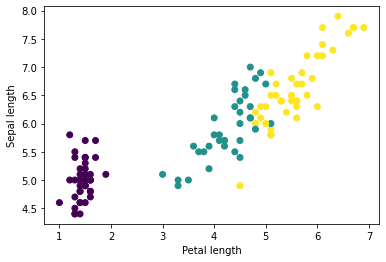

In [11]:
# again, lots of this code is just lifted straight from
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

# if you've not yet come across the joys of this `next(iter( ))`
# thing, here it is for the first (but probably not last) time!
features, labels = next(iter(train_dataset))

plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()
# but of course, you're likely quite familiar with this plot

- Note again how organized and structured (and cool!) this TF data set thing is with the data:

In [12]:
features
# labels


OrderedDict([('sepal_length',
              <tf.Tensor: shape=(120,), dtype=float32, numpy=
              array([5.4, 7.9, 6.2, 6.4, 6.3, 5.9, 6.1, 4.8, 5. , 5.2, 5.5, 7.7, 5. ,
                     6. , 5.8, 6.5, 4.9, 5.7, 7.6, 7.4, 5.6, 6.9, 7.7, 5. , 5. , 4.6,
                     5.6, 7.7, 5.4, 5.2, 6.7, 5.8, 6.3, 4.6, 5.5, 5.1, 4.9, 6.6, 6. ,
                     4.9, 6.9, 6.5, 6.3, 6.2, 6.7, 5.1, 5.6, 6.1, 5.1, 6.1, 7.2, 6.3,
                     5. , 5. , 5.7, 6.8, 5.7, 6.4, 6.6, 5. , 6. , 6.5, 6.9, 5.1, 5.1,
                     6.4, 5.4, 6.8, 5.5, 7.2, 4.9, 4.6, 6.7, 6.4, 5.8, 5.1, 5.7, 6.3,
                     5.9, 4.7, 6.1, 4.4, 4.8, 6.3, 5.7, 4.4, 5.3, 5.4, 6.8, 5. , 6.5,
                     6.5, 6.4, 4.6, 5.5, 4.7, 7. , 7.2, 6.1, 5.8, 5.4, 5. , 4.9, 7.7,
                     6.4, 5.7, 7.3, 4.4, 6.7, 5.2, 5. , 4.5, 5.8, 4.9, 5.8, 6. , 4.8,
                     6.2, 4.8, 6.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: shape=(120,), dtype=floa

- However...

  ML (and DL) just want that matrix `X`...
  
  so to feed this into a keras model, we'll need to use that structure

# Minibatch Data

In [13]:
# again, I'm just lifting this from
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

def pack_features_vector(features, labels):
    
    """Pack the features into a single array."""
    
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

pack_features_vector(features, labels)

(<tf.Tensor: shape=(120, 4), dtype=float32, numpy=
 array([[5.4, 3.9, 1.7, 0.4],
        [7.9, 3.8, 6.4, 2. ],
        [6.2, 2.2, 4.5, 1.5],
        [6.4, 3.2, 4.5, 1.5],
        [6.3, 2.7, 4.9, 1.8],
        [5.9, 3. , 5.1, 1.8],
        [6.1, 2.9, 4.7, 1.4],
        [4.8, 3. , 1.4, 0.3],
        [5. , 2. , 3.5, 1. ],
        [5.2, 2.7, 3.9, 1.4],
        [5.5, 2.4, 3.8, 1.1],
        [7.7, 2.8, 6.7, 2. ],
        [5. , 3.3, 1.4, 0.2],
        [6. , 3. , 4.8, 1.8],
        [5.8, 2.7, 5.1, 1.9],
        [6.5, 3.2, 5.1, 2. ],
        [4.9, 3.1, 1.5, 0.1],
        [5.7, 2.8, 4.5, 1.3],
        [7.6, 3. , 6.6, 2.1],
        [7.4, 2.8, 6.1, 1.9],
        [5.6, 2.9, 3.6, 1.3],
        [6.9, 3.2, 5.7, 2.3],
        [7.7, 3. , 6.1, 2.3],
        [5. , 2.3, 3.3, 1. ],
        [5. , 3.2, 1.2, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5.6, 2.7, 4.2, 1.3],
        [7.7, 2.6, 6.9, 2.3],
        [5.4, 3.9, 1.3, 0.4],
        [5.2, 3.4, 1.4, 0.2],
        [6.7, 3.3, 5.7, 2.1],
        [5.8, 4. , 

In [15]:
train_dataset

<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

In [14]:
train_dataset_packed = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset_packed))

features[:,:5]

<tf.Tensor: shape=(120, 4), dtype=float32, numpy=
array([[5.4, 3.9, 1.3, 0.4],
       [4.9, 2.5, 4.5, 1.7],
       [6.7, 3. , 5. , 1.7],
       [7.2, 3.6, 6.1, 2.5],
       [6. , 2.2, 5. , 1.5],
       [4.6, 3.1, 1.5, 0.2],
       [6.9, 3.1, 5.1, 2.3],
       [5.9, 3.2, 4.8, 1.8],
       [5.5, 2.4, 3.8, 1.1],
       [7. , 3.2, 4.7, 1.4],
       [6.3, 3.3, 4.7, 1.6],
       [6.4, 2.8, 5.6, 2.2],
       [4.5, 2.3, 1.3, 0.3],
       [6.5, 2.8, 4.6, 1.5],
       [5. , 3.5, 1.3, 0.3],
       [5.2, 3.5, 1.5, 0.2],
       [7.2, 3.2, 6. , 1.8],
       [4.4, 3. , 1.3, 0.2],
       [5.4, 3. , 4.5, 1.5],
       [5.1, 3.7, 1.5, 0.4],
       [6.6, 3. , 4.4, 1.4],
       [4.8, 3.1, 1.6, 0.2],
       [6.6, 2.9, 4.6, 1.3],
       [5.3, 3.7, 1.5, 0.2],
       [6. , 2.9, 4.5, 1.5],
       [5.7, 2.8, 4.5, 1.3],
       [5.8, 2.7, 5.1, 1.9],
       [6.3, 2.3, 4.4, 1.3],
       [4.9, 3.1, 1.5, 0.1],
       [6.1, 2.6, 5.6, 1.4],
       [6.3, 2.5, 5. , 1.9],
       [6.7, 3. , 5.2, 2.3],
       [4.6, 3.6, 1. ,

In [8]:
# repurposing the code from
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

file = "iris_test.csv"
test_dataset_fp = tf.keras.utils.get_file(fname=path+file, origin=test_url)

test_batch_size = 15
test_dataset = tf.data.experimental.make_csv_dataset(
    test_dataset_fp,
    test_batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=True)
# EXTREMELY IMPORTANT to shuffle... for the training set... should have done that up above?

test_dataset_packed = test_dataset.map(pack_features_vector)

NameError: name 'pack_features_vector' is not defined

In [ ]:
# tf.data.experimental.make_csv_dataset?
# ! head {test_dataset_fp}
# wc -l {test_dataset_fp}

- So what is this `next(iter())` thing about?

In [ ]:
next(iter(test_dataset_packed))

In [ ]:
#tmp = iter(test_dataset_packed)
#next(tmp)
test_dataset_packed

In [ ]:
next(tmp)

- Don't worry: you can instantiate a tf data set over and over and over each time you hit it in a `for` loop!
    - (which just calls the `iter()` instantiator on the thing you're looping over)
    - so, `for` loop set up calls `iter()`
    - and, `for` loop steps call `next()`
    - until it iterator ends

In [ ]:
for minibatch in test_dataset_packed:
    print(minibatch)

These iterator data set things are super cool... and actually, they're *generators*! 
- Which means?

# Model 1: two hidden layer composition

Here are a bunch of resources I looked at and found helpful in various ways!
- https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
- https://www.kdnuggets.com/2020/08/tensorflow-model-regularization-techniques.html
watch out, though: the world changes fast!
- https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
- https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [ ]:
# hopefully this should be readly interpretable to you by now!

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])
# Sometimes I prefer using an *explicit* keras `Input` layer: https://keras.io/api/layers/core_layers/input/
# but the above seems pretty reasonable as well... there are quite a few ways to do things in Keras

# trusty ol' `softmax`
tf.nn.softmax(model(features)[:5,:])

- Be Careful!
    - if we represented the binary classification output with a single column, then we'd need `sigmoid` activation
    - but if we were doing a binary classification using two columns, we'd need to use `softmax` activation instead!


Also note that this issue is different from how the output is encoded. As noted in [the documentation](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class):

> "Use [a `SparseCategoricalCrossentropy`] loss function when there are two or more label classes [and we] expect labels to be provided as integers. If you want to provide labels using `one-hot` representation, please use `CategoricalCrossentropy` loss"

- which seems a quite unfortunate use of the term "Sparse"...

And finally, also note that *crossentropy* IS *negative log loss*, and using a sigmoid output with with a single column representation, or a softmax output with a two column representation are equivalent (reparameterized) specifications, and both will (generally) use *crossentropy* for their loss... which is the same as *negative log loss* under a bernoulli specification.

### **Let's take a little spin through this model**:

In [ ]:
features

In [ ]:
tf.argmax(model(features), axis=1), labels

In [ ]:
model(features)

In [ ]:
dir(model)
dir(model.layers[0])
model.layers[0].trainable_variables
model.layers[2].trainable_variables


In [ ]:
plt.hist(model.layers[2].trainable_variables[0][:,0].numpy())
plt.hist(model.layers[2].trainable_variables[0][:,1].numpy())
plt.hist(model.layers[2].trainable_variables[0][:,2].numpy())


In [ ]:
plt.hist(model(features)[:,0].numpy())
plt.hist(model(features)[:,1].numpy())
plt.hist(model(features)[:,2].numpy())


In [ ]:
plt.hist(model(features).numpy()[labels.numpy()==0,0])
plt.hist(model(features).numpy()[labels.numpy()==1,0])
plt.hist(model(features).numpy()[labels.numpy()==2,0])


### **Now let's set up our model fitting**:

In [ ]:
# again, I'm just lifting this from
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
    
# note the "Sparse" is based on the labels being NOT being one-hot encoded... huh?/grrr...
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def grad(model, x, y):
    
    # "tape" here, as in "tape recorder"... because why not give new technology old technology names, amiright?
    with tf.GradientTape() as tape:
        loss_value = loss_object(y_true=y, y_pred=model(x, training=True)) 
                                                           # The model sometimes needs to work differently 
                                                           # during training and testing... 
                                                           # ... Anyone have a good example of this?
        
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Playing around with some optimizer choices for the vanilla set up... landed on the last one for now
# Optimizers will be discussed next class!  Can be a very crucial piece of the puzzle...
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9, epsilon=1e-07)


In [107]:
# again, I'm just re-crafting for my own purposes from the code at
# https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

def fit(model, train, test, num_epochs, test_epoch_modulus=10):

    train_loss_results = []
    train_accuracy_results = []
    train_epoch=list(range(num_epochs))
    test_loss_results = []
    test_accuracy_results = []
    test_epoch = []

    for epoch in range(num_epochs):

        # these help us manage "performance tracking" within an epoch while accounting for batches 
        epoch_training_loss_avg = tf.keras.metrics.Mean()
        epoch_training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        epoch_testing_loss_avg = tf.keras.metrics.Mean()
        epoch_testing_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in train:
            # Optimize the model
            loss_value, grads = grad(model, x, y)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Track progress
            epoch_training_loss_avg.update_state(loss_value)  # Add current batch loss
            # Compare predicted label to actual label
            # training=True is needed only if there are layers with different
            # behavior during training versus inference (e.g. Dropout).
            epoch_training_accuracy.update_state(y, model(x, training=True))

        # End epoch
        train_loss_results.append(epoch_training_loss_avg.result())
        train_accuracy_results.append(epoch_training_accuracy.result())

        # test data set -- probably not every time
        if epoch % test_epoch_modulus == 0:
            for x, y in test:
                y_pred = model(x, training=False)
                loss_value = loss_object(y_true=y, y_pred=y_pred)
                epoch_testing_loss_avg.update_state(loss_value)
                epoch_testing_accuracy.update_state(y, y_pred)

            test_epoch.append(epoch)
            test_loss_results.append(epoch_testing_loss_avg.result())
            test_accuracy_results.append(epoch_testing_accuracy.result())
            
    return {'train_epoch': train_epoch, 
            'test_epoch': test_epoch, 
            'train_loss_results': train_loss_results, 
            'test_loss_results': test_loss_results,
            'train_accuracy_results': train_accuracy_results, 
            'test_accuracy_results': test_accuracy_results}

# I have done this variable naming backwards... but below IS correct
# I'm overfitting to the smaller "Iris test data"
# and seeing how it generalizes "out of sample" 
results = dict()
result = 'Vanilla'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=2001)

# Model 1: two hidden layer composition

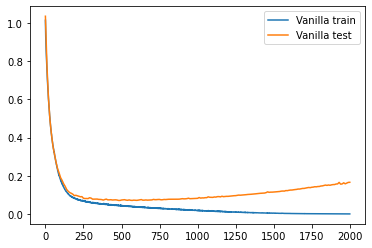

In [447]:
# Since I'm not getting test scores after each epoch,
# I need to "impute" some values to line up the train-test plots.
# Originally I thought I'd impute with loess
#
# https://towardsdatascience.com/loess-373d43b03564
# `! yes y | conda install statsmodels`
# from statsmodels.nonparametric.smoothers_lowess import lowess
#
# But then I decided rolling averages would be easier!
# https://www.datacamp.com/community/tutorials/moving-averages-in-pandas

# plot can now be reused easily for different models
def train_test_plot(label,x_train,y_train,x_test,y_test,w_train=1000,w_test=10):
    ax.plot(x_train, pd.Series(np.array(y_train)).rolling(window=w_train).mean(), label=label+' train')
    ax.plot(x_test, pd.Series(np.array(y_test)).rolling(window=w_test).mean(), label=label+' test')
    ax.legend()
    return ax

fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

#ax.set_ylim([0,0.2])


- Classical "overfitting"

(0.9, 1.01)

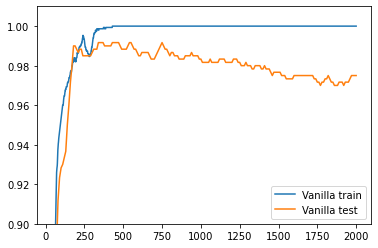

In [448]:

fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=5)

ax.set_ylim([0.9,1.01])

- And increasingly hurting the "bottom line" accuracy 

# Model 2: two hidden layer composition; dropout

- Yay, everyone's favorite! Right? ...RIGHT?? 
- But, I mean, look at this... it's NOT HARD to add this kind of regularization... 
    - If you're not at least exploring this you're not even trying!

In [453]:

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dropout(0.5), #dropout with 50% rate  
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.5, epsilon=1e-07)

result = 'Dropout'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=1501)
# again I'm "training" on "iris test" and scoring "out of sample" (i.e., "testing") on "iris training"
# just using the smaller (more idiosyncratic) data set for fitting, and then trying to generalize
# on the richer, i.e., BIGGER, "more representative" data set


(0.0, 0.2)

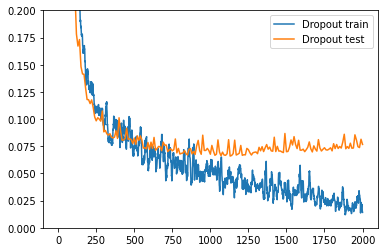

In [458]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=10,w_test=1)

ax.set_ylim([0,0.5])

- "Overfitting" doesn't start as soon
- Actually, testing scores better to start with!
    - it's often the case that generalization *is better* than the overfitting (i.e., training fit scores on itself)!!
    - The dropout is breaking "overfitting" while still allowing generalizing features to be found

(0.9, 1.01)

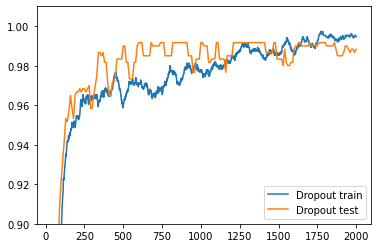

In [457]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=5)

ax.set_ylim([0.9,1.01])

- Even when we're clearly "overfitting" the generalization is *still* very good and not suffering!
- Dropout is learning generalizations *faster than it can overfit*!

# Model 3: two hidden layer composition; batch normalized

- This is a *legendary* breakthrough, on the order of ReLU...
    - it's *Game Changing* for optimization/model fitting... but that's a topic for next class
        - IT ALSO ACTUALLY WORKS AS REGULARIZATION, TOO! Whaaaaaaaat!?
- And again, this is so easy... how can you not be exploring this in your models?

In [683]:

# *GREATLY* reduced model size
model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(64), 
  tf.keras.layers.BatchNormalization(), # the Deep Learning textbook recomends this order (before RELU)
  tf.keras.layers.ReLU(), # however, empiricaly it seems BatchNorm *after* 
  tf.keras.layers.Dense(32),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.ReLU(),  
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000175, beta_1=0.999, beta_2=0.999, epsilon=1e-07)

result = 'Batch_Normalized'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=4001, test_epoch_modulus=50)
# same story as explained above: intentionally flipped train/test for demo purposes


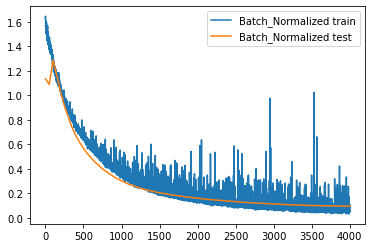

In [684]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=1,w_test=1)

#ax.set_ylim([0,0.2])

- We need to "learn slower" with this 
    - so we can "ease" into stable feature "centering and scaling"... 
    - the centering and scaling effects can be too reactive/sporadic if we change them too quickly
- But notice how again (like dropout) "Generalization" happens faster than "Overfitting"
- And we're not getting the same loss as before (but the model is so much smaller!)


- **What's happening is that `BatchNorm` is adding a little noise into the higher data abstractions**
    - THIS IS DATA AUGMENTATION
    - subsequent feature engineering in the network needs to find generalizations that can handle this sort of noise and variation in the data!


(0.9, 1.01)

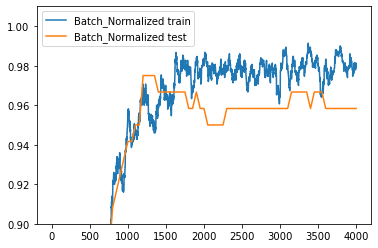

In [685]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=1)

ax.set_ylim([0.9,1.01])

- With a MUCH simpler model, we've been able relatively quickly find very good generalizations


- The "zig-zag" pattern is because changes to the "centering and scaling" can cause major "inadvertant shakups" to the network, breaking it out of the trajectory the model was initially following on the loss function

# Model 4: two hidden layer composition; data augmentation

- Check this out: you're gonna like this
    - and again, it's too easy to try this out to not be doing it...

In [635]:

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GaussianNoise
import tensorflow_probability as tfp

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tf.keras.layers.Dense(1024), 
  tf.keras.layers.ReLU(),  
  tf.keras.layers.GaussianNoise(.1), # this needs to be carefully scaled! It's another tuning parameter...
  tf.keras.layers.Dense(512),
  tf.keras.layers.ReLU(),  
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.9, epsilon=1e-07)

result = 'Data_Augmentation'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=1001, test_epoch_modulus=50)


(0.0, 0.5)

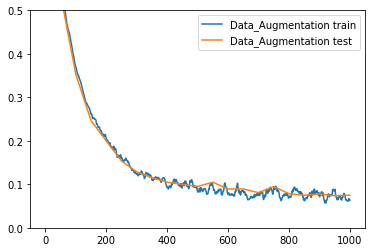

In [636]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=10,w_test=1)

ax.set_ylim([0,0.5])

- That's wild... it's like it's not even overfitting!
- Anyway, here, we're just directly explicitly doing data augmentation at at higher levels of data abstractions/featurizations

(0.9, 1.01)

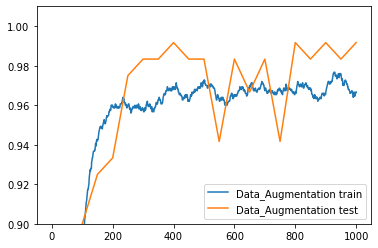

In [637]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=1)

ax.set_ylim([0.9,1.01])

- We're generalizing better than training overfitting
- because we're not fitting on a limited training set:
    - we're using TONS of purtibations/variations of that data set

# Model 5: two hidden layer composition; random weights
- This is Bayesian... ooo...
- Instead of adding noise to the actvations (features):
    - assume the weights (parameters) have distributions
        - which we sample from
        
        
- Surprise: it's not hard to do this...

In [654]:

# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout
import tensorflow_probability as tfp

model = tf.keras.Sequential([
  tf.keras.Input(shape=(4,)),
  tfp.layers.DenseFlipout(1024), 
  tf.keras.layers.ReLU(), 
  tf.keras.layers.Dense(512),
  tf.keras.layers.ReLU(),  
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.99, beta_2=0.99, epsilon=1e-07)

result = 'Random_Weights'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=1001, test_epoch_modulus=50)



(0.0, 0.5)

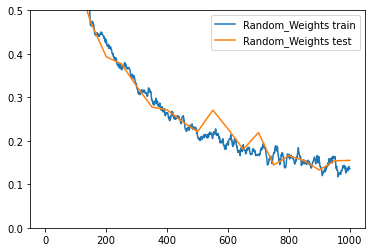

In [655]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=10,w_test=1)

ax.set_ylim([0,0.5])

- Same story as data augmentation: it's lke we're not even overfitting
    - again, because it's actually working with "SO MUCH" data

(0.9, 1.01)

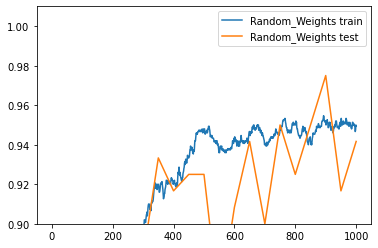

In [656]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=1)

ax.set_ylim([0.9,1.01])

- It *IS* "harder" to get "top predction scores"
- but that's because you're allowing for uncertainty, rather than just "choosing the best"

# Model 6: two hidden layer composition; weight decay

- Not hard to use...


In [669]:

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape=(4,), # input shape required
                        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)), 
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000025, beta_1=0.9, beta_2=0.9, epsilon=1e-07)

result = 'Weight_Decay'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=1001, test_epoch_modulus=50)



(0.0, 0.5)

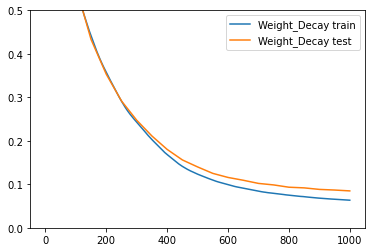

In [670]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=10,w_test=1)

ax.set_ylim([0,0.5])

- Pretty sweet. Overfitting happens more slowly with this weight decay regularization

(0.9, 1.01)

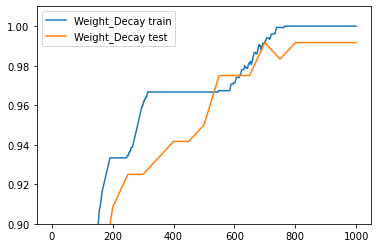

In [671]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=1)

ax.set_ylim([0.9,1.01])

- Nice: working sweet!

# Model 7: two hidden layer composition; sparse representation

- Not hard to use...

In [675]:

model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape=(4,)), # input shape required
  tf.keras.layers.Dense(512, activation=tf.nn.relu,
                        activity_regularizer=tf.keras.regularizers.l1(l1=0.01)),
  tf.keras.layers.Dense(3)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000025, beta_1=0.9, beta_2=0.9, epsilon=1e-07)

result = 'Sparse_Representation'
results[result] = fit(model, train=test_dataset_packed, test=train_dataset_packed, num_epochs=1001, test_epoch_modulus=50)



(0.0, 0.5)

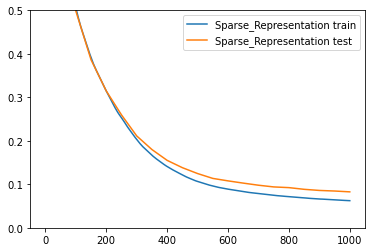

In [676]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_loss_results'],
                     results[result]['test_epoch'], results[result]['test_loss_results'], 
                     w_train=10,w_test=1)

ax.set_ylim([0,0.5])

- Looks "about the same" as weight decay regularization

(0.9, 1.01)

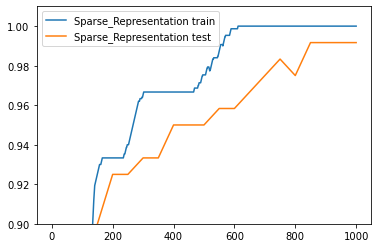

In [677]:
fig, ax = plt.subplots()

ax = train_test_plot(result,
                     results[result]['train_epoch'], results[result]['train_accuracy_results'],
                     results[result]['test_epoch'], results[result]['test_accuracy_results'], 
                     w_train=50,w_test=1)

ax.set_ylim([0.9,1.01])

- And seems able to again perform comparably to weight decay regularization

# Done
Except
- early stopping
Except
- we did (implicitly)


# My usual notes (taken from my own textbook reading)

regularization: reduce test error (likely at expense of training error)... "any modiﬁcation we make to alearning algorithm that is intended to reduce its generalization error but not itstraining error."

- constraints
- extra terms on objective functions
- encode certain prior knowledge
- express generic preference for a simpler model
- to make an underdetermined problem determined
- "ensemble methods" combine multiple hypotheses
- DL is mostly based on regularizing estimators: trades incresed bias for reduced variance

Parameter Norm Pentalties

$\tilde J(W, b; X, y) = J(W, b; X, y) + \alpha \Omega(W), \alpha \geq 0$

- in DL weights can be penalized
- L1 regularization lets them hit zero, that would basically never happen L2 
- "reprojection": since applying L1/L2 is equivalent to a constraint on parameter size, just implementing bounds on parameters can acheive this.  And it helps with "dead units"
    - "dead units": units with weights that are essentially zero so nothing comes out of this unit
        - using reprojection (forcing parameter value constraints to be respected) rather than shrinkage could be better since it doesn't actually specifically encourage weights pushed towards 0.
     
Data Augmentation:

- *If* $x \mapsto y \iff f(x) \mapsto y$, then $f(x)$ makes new data (in a classification context
    - but you need to have $f$... think, e.g., "mirror image", or "a little random noise"
    
Noise:
- Bayesians would have weights be unknown random variables with distributions 
    - stochastically this can be implemented practically by allowing noise (i.e., this distributional uncertainty) to be added to weights
    
- Errors in outcome labels can be addressed by using soft probabilities which include errors $1-\epsilon$ and $\frac{\epsilon}{k-1}$ for the other k-1 categories

Semi-Supervised Learning:
- An unsupervised specification can "express a prior belief" (i.e., influence the form taken by) the supervised specification solution
    - I.e., $P(X,Y)$, $P(X)$ and $P(Y|X)$ have shared and overlapping parameters, so
        - unlabeled data can be considered using $P(X)$ 
        - labeled data can be considered using $P(X,Y)$
        - and if these are considered together (i.e., the cross-entropies of these are used in the same loss function)
            - $-log P(X) -log P(Y|X)$ 
            - $-log P(Y,X) -log P(Y|X)$ 
        - then $P(X)$ and $P(X,Y)$ (respectively) can influence the final form taken by $P(Y|X)$
    
Multi-Task Learning:
- regularize an underlying representation to be effective for multiple output tasks

Early Stopping:
- simplest form of regularization
    - "efficient hyperparameter selection"
    - controls "the effective capacity" of the model
    - can be seen as a monitored form of *weight decay* (L2 regularization)

Parameter Dependence:
- parameters should be close to each other: $\alpha||W_1 - W_2||$s
- force them to be equal: parameter sharing
    - CNNs
    
Sparse Representation or Representational regularization:

$\tilde J(\theta; X, y) = J(\theta; X, y) + \alpha \Omega(h), \alpha \geq 0$, where $h$ is the activations
- E.g., the average activation for a node across a given batch of data might be targetted at "1%": $\frac{1}{m}
- $\Omega$ as L1, Student t prior, KL divergence penalties can all acheive this.
 \sum_i h_j^{(i)} \approx 0.01$
- also can use orthogonal matching pursuit: $argmin \underset{h, ||h||_0<k}{||x - Wh||^2}$ (OMP-$k$) where $k$ indicates number of non-zero entries in $h$.

Bagging, and other Ensemble Methods:
- provides Model Averaging
- averaged uncorrelated predictions reduce error -- there's a formula for how much reduction that you should be familiar with
- averaging stabilizes things -- provides regularization
    - boosting on the other hand is an ensemble method that's not meant provide regularization
        - boosting is meant to increase capacity
        
Dropout:
- "To a ﬁrst approximation,dropout can be thought of as a method of making bagging practical for ensembles of very many large neural networks"
    - "In the case of bagging, the models are all independent. In the case of dropout, the models share parameters, with each model inheriting a diﬀerent subset of parameters from the parent neural network."
- "Dropout provides an inexpensive approximation to training and evaluating a bagged ensemble of exponentially manyneural networks"
- "dropout trains the ensemble consisting of all subnetworks that can be formed by removing nonoutput units from an underlying base network"
- "Typically, an input unit is included with probability 0.8, and a hidden unit is included with probability 0.5"
- "weight scaling inference rule": multiply output by expected value of mask (0.5 above)
    - empirically this can work very well, though it's not exaxt becaues of the non-linearities... it's an approximation that works well.
    
- Easy to apply
- But it weakens the model, so often requires a more complex model on which to apply regularization in order to get good benefit
- May not be so useful when there's a lot of data already

- this approach to bagging offers benefits beyond "averaging regularization"... it forces features to be robust in different contexts
- "Destroying extracted features rather than original values allows the destruction process to make use of all the knowledge about the input distribution that the model has acquired so far"

- important to note that noise is multiplicative
- batch normalization (discussed more in the optimization chapter) can also add additive AND multiplicative noise, and so can also add some regularization benefit

Adversarial Training:
- Can you find examples that seem to not work?  If so, include these in your training!
- This serves to enforce a local constancy prior

Manifold Hypothesis:

- tangent distance algorithm:  "nonparametric nearest neighbor algorithm in which the metric used is ... derived from knowledge of the manifolds near which probability concentrates."
- assumes "examples on the same manifold share the same category"
    - "uses, as nearest neighbor distance between points x1 and x2, the distance between the manifolds M1 and M2 to which they respectively belong"
        - constructed/approxmately calculated by distances between tangents approximating manifolds
    
- tangent prop algorithm: 
    - penalize lack of orthogonality of "direction" (i.e., gradient) of decision function $\nabla f$ relative to pre-computed manifold tangents $v^{(i)}$
    - very related to performing data augmentation in the direction of manifolds, but data augmentation seems to have some advantages over this because the gradient approach is (a) infinitesimal, and (b) ReLU gradients don't shrink unless they get turned off or have shrunken weights... having a penalty that wants orthogonal OR SMALL gradients could mess with this.
    - also related to double backprop (regularizing the Jacobian to be small) and adversarial training (the data augmentation version of double backprop) i.e., making sure small pertubations of data are still classified the same as their original value
    
- manifold tangent classiﬁer:
    - avoid needing preknowledge of manifold tangents:
    1. "use an autoencoder to learn the manifold structure by unsupervised learning"
    2. "use these tangents to regularize a neural net classiﬁeras in tangent prop"


A few other interesting pointers to take note of from the reading:
- Instead of "Frobenius norm of the entire weight matrix", "constraining the norm of each column of the weight matrix" "prevents any one hidden unit from having very large weights"
    - "In practice, column norm limitation is always implemented as an explicit constraint with reprojection" with "KKT multipliers" "dynamically updated separately to make each hidden unit obey the constraint"

- $X^TX$ may not be invertible, but $X^TX + \alpha I$ is
- The Moore-Penrose pseudoinverse $\underset{\alpha \rightarrow 0}{\lim} (X^TX + \alpha I)^{-1}X^T$ can be seen to be using this trick!
- Data augmentation alone might make a certain algorithm outperform another when in fact it's the data augmentation itself which is providing the gains...
- An interesting regularization term includes $\nabla W$ and thereby encourages $W$ in "flat" regions (where the gradient is closer to 0)

- NN Ensembles can be created in in different ways besides dropout: multiplying activations by $N(1,I)$ "automatically implements approximate inference in the ensemble, without needing any weight scaling": i.e., being Bayesian, and then making expected value predictions of the distributions of the parameters